In [2]:
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
from scipy.special import erf, spherical_jn
%matplotlib inline

from pyccl import halos
from classy import Class

## Approach for generating EFT model:

#### This approach:
For EFT contribution, use $P(k,z) = P_\mathrm{tree}(k,z) + P_\mathrm{1-loop}(k,z) + c_s P_\mathrm{counterterm}(k,z)$
where $P_{i}$ includes IR resummation, so isn't exactly factorizable. All these can be gotten from appropriately IR resummed CLASS-PT / FAST-PT. 
#### Approximate (faster) approach: 
Just assume that components are factorizable, such that $P(k,z) = \left(\frac{D(z)}{D(z_r)}\right)^2P_\mathrm{tree}(k,z_r) + \left(\frac{D(z)}{D(z_r)}\right)^4P_\mathrm{1-loop}(k,z_r) + c_s \left(\frac{D(z)}{D(z_r)}\right)^4P_\mathrm{counterterm}(k,z_r)$
where $z_r$ is some reference redshift. This ignores the $z$ dependence of IR resummation, but is a fair approximation (e.g. using $z_r = 0$ gets $\sim 1\%$ errors by $z = 3$). In this case, one could use a much denser $z$ grid.

#### Load in Quijote cosmology

In [58]:
Omega_c = (0.3175-0.049)
Omega_b = 0.049
h = 0.6711
A_s = 2.134724e-09
n_s = 0.9624
N_eff = 3.046

#### Initialize CCL

In [64]:
# Load in CCL Cosmology
cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, A_s = A_s, n_s=n_s,Neff=N_eff,
                      transfer_function='boltzmann_class')

# Generate scale factors
a_arr = np.linspace(0.1,1,36)
z_arr = 1./a_arr-1.

In [65]:
# Create list of redshifts for CLASS input
# (CLASS-PT doesn't seem to be able to interpolate up to z_max unlike CLASS)
z_str = ""
for z_i in range(len(z_arr)):
    z_str += "%s"%z_arr[z_i]
    if z_i<len(z_arr)-1:
        z_str+=", "

#### Initialize CLASS-PT

In [66]:
cosmol = Class()
# Set class parameters
cosmol.set({'k_pivot':'0.05',
        'A_s':A_s,
        'n_s':n_s,
        'h':h,
        'Omega_b':Omega_b,
        'N_eff':N_eff,
        'Omega_cdm':Omega_c,
        'P_k_max_h/Mpc': '101.',
        'output':'mPk',
        'z_pk':z_str,
        'z_max_pk':101,
        'non linear':' PT ',
        'IR resummation':' Yes ',
        'Bias tracers':' No ',
        'RSD':' No ',
        #'AP':'Yes',
        'FFTLog mode':'SLOW', # either PRECISE / SLOW needed for accuracy (SLOW is faster)
        'Omfid':Omega_c+Omega_b
        })
# Compute CLASS and set nuisance parameters
cosmol.compute()

#### Create Pk2D operators from CLASS-PT

In [67]:
# Linear matter power spectrum (no loops)
def lin_power(k,z):
    kk = np.vstack([k for _ in range(len(z))]).T[:,:,np.newaxis]
    zz = np.asarray(z)
    return cosmol.get_pk_lin(kk,zz,len(k),len(zz),1)[:,:,0]

In [68]:
# 1-loop IR-resummed matter power spectrum (real space)
h = cosmol.h()


# Load in all components from CLASS-PT
lk_arr = np.log(10.**np.linspace(-4,1,256))
k_arr = np.exp(lk_arr)

def one_loop_power(k,z):
    # This separates out the contribution without / with the counterterm to allow for easy fitting.
    # Full power is pk_no_cs + cs * pk_cs
    # NB: We assume counterterm is in [1/Mpc] units - this is unconventional.
    kk = np.vstack([k for _ in range(len(z))]).T[:,:,np.newaxis]
    zz = np.asarray(z)
    
    # Load in all components from CLASS-PT
    pk_comp = cosmol.get_pk_comp(kk,zz,len(k),len(zz),1)[:,:,:,0]
    # Reconstruct power spectrum in [Mpc]^2 units
    # NB: pk_comp[14] is tree-level term, pk_comp[0] is one-loop, pk_comp[10] is counterterm
    pk_no_cs = (pk_comp[14] + pk_comp[0])
    pk_cs = (2.*pk_comp[10])
    
    return pk_no_cs, pk_cs

#### Create and plot the contributions for reference

In [69]:
lk_arr = np.log(10.**np.linspace(-4,1,256))
k_arr = np.exp(lk_arr)

pk_arr = lin_power(np.exp(lk_arr),z_arr)
pk_arr_no_cs, pk_arr_cs = one_loop_power(np.exp(lk_arr),z_arr)

Text(0, 0.5, '$P(k)$')

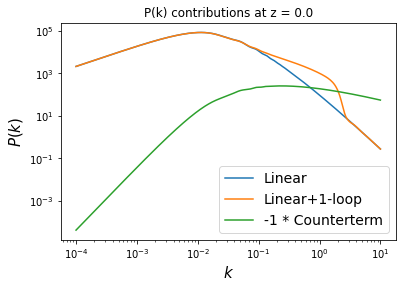

In [70]:
plt.title('P(k) contributions at z = %.1f'%z_arr[-1])
plt.loglog(np.exp(lk_arr),pk_arr[:,-1],label='Linear');
plt.loglog(np.exp(lk_arr),pk_arr_no_cs[:,-1],label='Linear+1-loop');
plt.loglog(np.exp(lk_arr),-pk_arr_cs[:,-1],label='-1 * Counterterm');
plt.xlabel(r'$k$',fontsize=15)
plt.legend(fontsize=14)
plt.ylabel(r'$P(k)$',fontsize=15)

Generate other CCL halo quantities

In [71]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

# Load in the halo model calculator object
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m)

Prepare counterterm piece and smoothing

In [72]:
k_hat = h # turn-over for Pade resummation of counterterm 
print('Note that this value is quite arbitrary, but setting to k-hat = 1 h/Mpc seems to work')

# create counterterm including Pade resummation and z scaling but without cs_{z = 0} factor
counterterm_piece = pk_arr_cs.T/(1.+(k_arr/k_hat)**2.)

Note that this value is quite arbitrary, but setting to k-hat = 1 h/Mpc seems to work


#### Compute standard halo model

In [74]:
lin_pk = ccl.Pk2D(a_arr=a_arr,lk_arr=lk_arr,pk_arr=pk_arr.T,is_logp=False)

# create Pk2D objects with halo terms (a) linear theory, (b) Standard Halo Model, (c) 1-halo
pk_MMf_lin = ccl.halos.halomod_Pk2D(cosmo, hmc, pM,
                                normprof1=True,p_of_k_a=lin_pk,
                                lk_arr=np.log(k_arr), a_arr=a_arr,get_1h=False)
pk_MMf_shm = ccl.halos.halomod_Pk2D(cosmo, hmc, pM,
                                normprof1=True,p_of_k_a=lin_pk,
                                lk_arr=np.log(k_arr), a_arr=a_arr)
pk_MMf_1h = ccl.halos.halomod_Pk2D(cosmo, hmc, pM,
                                normprof1=True,p_of_k_a=None,
                                lk_arr=np.log(k_arr), a_arr=a_arr,get_2h=False)

#### Load in EffectiveHalos for testing

In [98]:
# or just import EffectiveHalos if it's pip installed
import sys
sys.path.append('/home/ophilcox/EffectiveHalos/')
import EffectiveHalos as eh

In [76]:
cc = eh.Cosmology('Quijote')
mf = eh.MassFunction(cc,'Bhattacharya')
hp = eh.HaloPhysics(cc,mf)

### Now fit to Quijote at fixed $z$
**NB**: Using 'EffectiveHalos' instead of 'CCL' for 'backend' will give results from the 'EffectiveHalos' Python package, without the complexities of CCL. This is based on standard CLASS with FAST-PT and custom IR resummation.

In [77]:
## Load all Quijote fiducial high resolution power spectra and convert units
all_quijote_pk = np.load('/home/ophilcox/quijote_fid_HR_all_Pk.npy')
kQ = all_quijote_pk[0,0,:]*h
all_z = [0,0.5,1,2,3]
backend = 'CCL' # 'EffectiveHalos' # choice of backend for doing halo-model calculations

Using backend CCL
Optimal parameters are c_s^2 = 9.74, R = 2.47


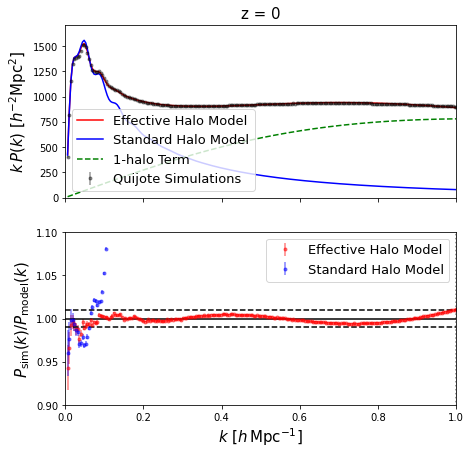

Using backend CCL
Optimal parameters are c_s^2 = 4.66, R = 1.78


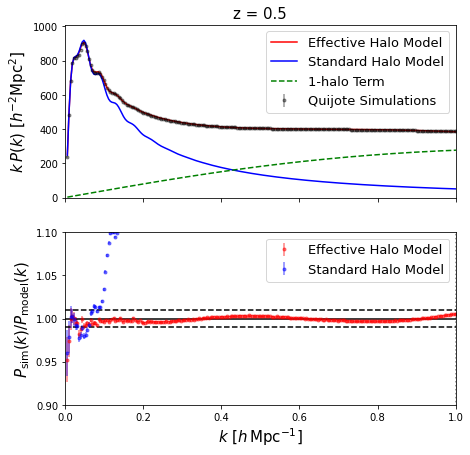

Using backend CCL
Optimal parameters are c_s^2 = 2.29, R = 1.24


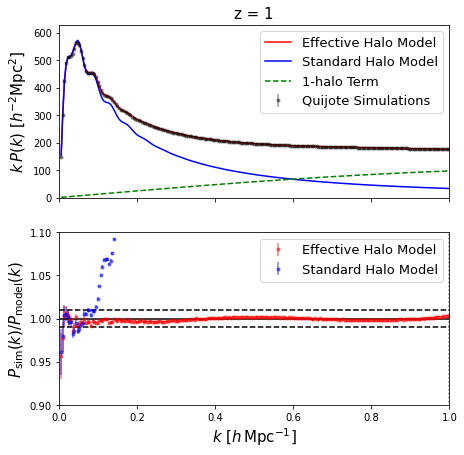

Using backend CCL
Optimal parameters are c_s^2 = 0.68, R = 0.61


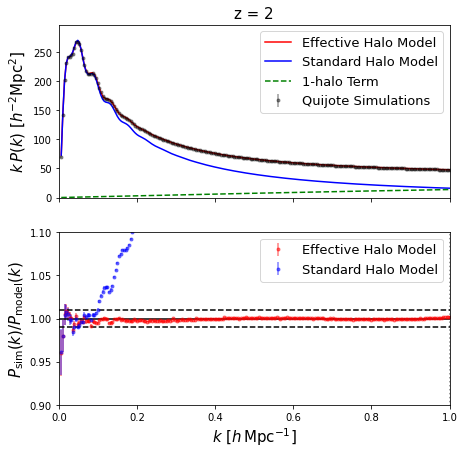

Using backend CCL
Optimal parameters are c_s^2 = 0.28, R = 0.36


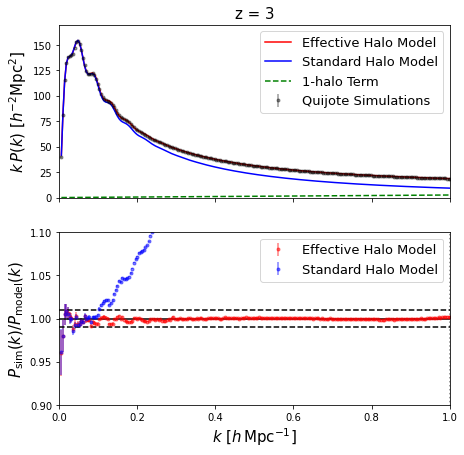

In [78]:
all_cs0,all_R0 = [],[]
for z_ind in range(len(all_z)):
    this_z = all_z[z_ind]
    this_a = 1./(this_z+1.)

    PkQ = all_quijote_pk[:,z_ind+1,:]/h**3
    PkQmean = PkQ.mean(axis=0)
    PkQstd = PkQ.std(axis=0)/np.sqrt(len(PkQ))

    kMax = 1. # fitting k
    filt = kQ<kMax
    
    print("Using backend %s"%backend)
    
    if backend=='EffectiveHalos':
        ## Effective Halos backend
        hm = eh.HaloModel(cc,mf,hp,kQ/h,this_z)
        pk_eft_simple = lambda cs0,R0: hm.halo_model(cs0,R0,'EFT',1,1,1)/h**3.
        pkQ_lin,_,pkQ_1h = hm.halo_model(-1,-1,'Linear',0,0,1,return_terms=True)
        pkQ_lin/=h**3.
        pkQ_1h/=h**3.
        
    elif backend=='CCL':
        # Compute CCL spectra at these k
        pkQ_lin = pk_MMf_lin.eval(kQ,this_a,cosmo)
        pkQ_1h = pk_MMf_1h.eval(kQ,this_a,cosmo)

        # Create simple function for fitting
        
        tmpL_pk = ccl.Pk2D(a_arr=a_arr,lk_arr=lk_arr,pk_arr=pk_arr.T,is_logp=False).eval(kQ,this_a,cosmo)
        tmp1_pk = ccl.Pk2D(a_arr=a_arr,lk_arr=lk_arr,pk_arr=pk_arr_no_cs.T,is_logp=False).eval(kQ,this_a,cosmo)
        tmp2_pk = ccl.Pk2D(a_arr=a_arr,lk_arr=lk_arr,pk_arr=counterterm_piece,is_logp=False).eval(kQ,this_a,cosmo)
        tmp1h = pk_MMf_1h.eval(kQ,this_a,cosmo)

        def pk_eft_simple(cs0,R0):
            kRtmp = kQ*R0
            WkR = 3.*spherical_jn(1,kRtmp)/kRtmp
            return (tmp1_pk+tmp2_pk*cs0)*WkR**2.+tmp1h
    else:
        raise Exception('wrong backend!')

    # Create a simple Gaussian likelihood
    def likelihood_simple(parameters):
        cs0, R0 = parameters
        if R0<0: return 1e10
        model_Pk = pk_eft_simple(cs0,R0)[filt]
        return np.sum((model_Pk - PkQmean[filt])**2. / PkQstd[filt]**2.)

    # Optimize free parameters
    from scipy.optimize import minimize
    p0 = [1., 1.]
    output = minimize(likelihood_simple, p0)
    cs0opt, R0opt = output.x
    all_cs0.append(cs0opt)
    all_R0.append(R0opt)
    print("Optimal parameters are c_s^2 = %.2f, R = %.2f"%(cs0opt, R0opt))

    # Compute optimal P(k)
    pkQ_eft = pk_eft_simple(cs0opt,R0opt)#.eval(kQ,1.,cosmo)

    # Plot the results
    fig,ax=plt.subplots(2,1,figsize = (7,7),sharex=True)
    ax[0].plot(kQ, kQ * pkQ_eft, c = 'r', label = 'Effective Halo Model')
    ax[0].plot(kQ, kQ * pkQ_lin, c = 'b', label = 'Standard Halo Model')
    ax[0].errorbar(kQ, kQ * PkQmean, yerr = kQ * PkQstd, ls = '', marker = '.', c = 'k', label = 'Quijote Simulations', alpha=0.4)
    ax[0].plot(kQ, kQ * pkQ_1h, ls = '--', c = 'g', label = '1-halo Term')
    ax[0].set_ylabel(r'$k\,P(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]', fontsize = 15)
    ax[0].set_title(r'z = %s'%this_z, fontsize = 15)
    ax[0].legend(fontsize = 13)
    ax[0].set_xlim([0,1.])
    ax[0].set_ylim([0,max((kQ*pkQ_lin)[filt])*1.1])
    ax[1].errorbar(kQ, PkQmean / pkQ_eft, yerr = PkQstd / pkQ_eft, ls = '', 
                   alpha=0.5, marker = '.', c = 'r', label = 'Effective Halo Model')
    ax[1].errorbar(kQ, PkQmean / pkQ_lin, yerr = PkQstd / pkQ_lin, ls = '', 
                   alpha= 0.5, marker = '.', c = 'b', label = 'Standard Halo Model')
    ax[1].set_xlabel(r'$k$ [$h\,\mathrm{Mpc}^{-1}$]', fontsize = 15)
    ax[1].set_ylabel(r'$P_\mathrm{sim}(k) / P_\mathrm{model}(k)$', fontsize = 15)
    ax[1].legend(fontsize = 13)
    ax[1].vlines(kMax,-1,3,linestyles=':',color='gray')
    ax[1].hlines(1., 0, 1)
    ax[1].hlines([0.99, 1.01], 0, 1, linestyles = '--')
    ax[1].set_ylim([0.9,1.1])
    plt.show()

Test out cosmology dependence of parameters to get rough idea of scaling (note these are quite covariant, so it will necessarily be approximate).

Text(0.5, 0, '$z$')

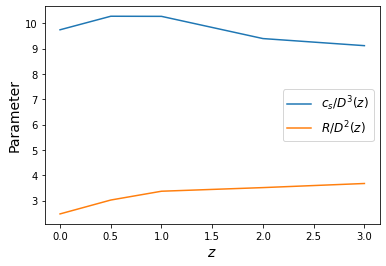

In [82]:
DzQ = np.asarray([cosmol.scale_independent_growth_factor(zz) for zz in all_z])
onePz = np.asarray([1+zz for zz in all_z])
plt.plot(all_z,np.asarray(all_cs0)/DzQ**3.,label=r'$c_s/D^3(z)$')
plt.plot(all_z,np.asarray(all_R0)/DzQ**2.,label=r'$R/D^2(z)$')
plt.ylabel(r'Parameter',fontsize=14)
plt.legend(fontsize=12)
plt.xlabel(r'$z$',fontsize=14)

##### Notes on compatibility with EffectiveHalos:

Note that EffectiveHalos and CCL/CLASS-PT use slightly different free parameter definitions.

To convert use $R_{CCL} = R_{EH}/h$, $c_{s,CCL}^2 \approx 1.11 c_{s,EH}^2$

Also note that EffectiveHalos natively works in $h/\mathrm{Mpc}$ units whereas CCL/CLASS-PT is in $1/\mathrm{Mpc}$.

Elsewise, they're in subpercent agreement at $z = 0$.

## 2D power spectra and $C_\ell$s

First, create a simple WeakLensing tracer to associate with the matter overdensity.

In [83]:
tracer_z_arr = np.linspace(0,1.,256)
nz_arr = np.exp(-((tracer_z_arr - 0.25) / 0.05)**2)

# Create weak lensing tracer field
t_M = ccl.WeakLensingTracer(cosmo, (tracer_z_arr, nz_arr))
#t_CMB = ccl.CMBLensingTracer(cosmo,1090.) # should this be 1090 or late time?

#### Load in $\ell$ and linear $C_\ell$ for shear

In [84]:
l_arr = np.unique(np.geomspace(2, 10000, 64).astype(int))

cl_MM_lin = ccl.angular_cl(cosmo, t_M, t_M, l_arr, p_of_k_a=pk_MMf_lin)
cl_MM_shm = ccl.angular_cl(cosmo, t_M, t_M, l_arr, p_of_k_a=pk_MMf_shm)
cl_MM_1h = ccl.angular_cl(cosmo, t_M, t_M, l_arr, p_of_k_a=pk_MMf_1h)

In [85]:
Dz_arr = ccl.growth_factor(cosmo,1./(1.+z_arr))

#### Create function for $C_\ell$ with EFT
(This would be used to set $c_s$ and $R$ from data properly)

In [94]:
## Full likelihoood
def cl_eft(cs0, R0):
    """Inputs: counterterm cs and smoothing R at z = 0.
    Output: Pk2D object of halo model at given cs0, R"""
    
    # First compute Rz
    Rz = R0*Dz_arr**2.
    csz = (cs0*Dz_arr**3.)[:,np.newaxis]
    
    # Compute smoothing function 
    kRz = k_arr[:,np.newaxis]*Rz[np.newaxis,:]
    WkRz = 3.*spherical_jn(1,kRz)/(kRz)
    
    # Compute Pk array without 1-halo term
    pk_arr_eft = (pk_arr_no_cs.T + csz*counterterm_piece)*WkRz.T**2.
    eft_pk = ccl.Pk2D(a_arr=a_arr,lk_arr=lk_arr,pk_arr=pk_arr_eft,is_logp=False)

    # Now compute halo model prediction
    pk_MMf_eft = ccl.halos.halomod_Pk2D(cosmo, hmc, pM,
                                normprof1=True,p_of_k_a=eft_pk,
                                lk_arr=np.log(k_arr), a_arr=a_arr)
    
    # Convert to Cl space
    cl_MM_eft = ccl.angular_cl(cosmo, t_M, t_M, l_arr, p_of_k_a=pk_MMf_eft)
    
    return cl_MM_eft

#### Plot shear results

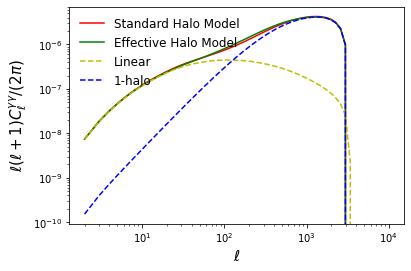

In [97]:
# Load in constants at z = 0 (should properly be set from data)
this_cs0 = all_cs0[0]
this_R0 = all_R0[0]

plt.figure()
lfac = l_arr * (l_arr + 1) / (2 * np.pi)
plt.plot(l_arr, lfac * cl_MM_shm, 'r-', label='Standard Halo Model')
plt.plot(l_arr, lfac * cl_eft(this_cs0,this_R0), 'g-', label='Effective Halo Model')
plt.plot(l_arr, lfac * cl_MM_lin, 'y--', label='Linear')
plt.plot(l_arr, lfac * cl_MM_1h, 'b--', label='1-halo')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left', fontsize=12, ncol=1, frameon=False)
plt.ylabel(r'$\ell(\ell+1)C^{\gamma\gamma}_\ell/(2\pi)$', fontsize=15)
plt.xlabel(r'$\ell$', fontsize=15);